# Celestial Object Classification
#### Names: Hai Hoang, Eddie Cazares, Katherine Clark, Adi Behre

## 1.0 Data Source

This notebook uses the **Sloan Digital Sky Survey - DR18** dataset, which is publicly available on Kaggle.
*   **Dataset Name:** Sloan Digital Sky Survey - DR18
*   **Original Creator:** diraf0
*   **Source:** [Sloan Digital Sky Survey - DR18](https://www.kaggle.com/datasets/diraf0/sloan-digital-sky-survey-dr18/data)
*   **Access Date:** November 11, 2024

## 1.1 Purpose
The Sloan Digital Sky Survey (SDSS) has produced a massive catalog of celestial objects. With millions of objects recorded, it's not feasible to classify them all manually.\
The goal here is to use machine learning techniques in order to build a model that can automatically classify an object as star, galaxy, and quasar. We will be using a public dataset of 100,000 objects from SDSS. Our process will be to clean the data, explore its key patterns, and train on several different machine learning models. The best model will be the one that can effectively use an object's features (like colors and redshift) to make an accurate prediction.

### About this dataset

This dataset consists of 100,000 observations from the Data Release 18 of the Sloan Digital Sky Survey (SDSS).
Each observation is described by 42 features and 1 class column classifying the observation as either:

- a STAR
- a GALAXY
- a Quasi-Stellar Object (QSO) or a Quasar.

#### Notebook Flowchart
- Load data + Data Cleaning & Preprocessing
- Check for missing / dupes and clean class labels
- Visualize class distribution
- Detect and handle outliers

In [26]:
# Data loading
import pandas as pd
import math
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Train models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, f1_score, recall_score, make_scorer, precision_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# Hyperparameter tuning
import optuna

## 2.0 Data Preprocessing
- No missing or NaN values in the dataset.
- Classification feature only includes GALAXY, STAR, QSO

### Notes
- ugriz photometry used to infer surface temperature and other physical properties, "as well as identify and classify different types of celestial objects".
    - u: ultraviolet, g: green light, r: red light, i: near-infrared light, z: further infrared light
    - each physical property is measured independently through each of the five color filters
- psfMag (or Point Spread Function) magnitudes help in characterizing brightness and colors of objects. Useful for stars.
- petroRad (or Petrosian radius) is the measurement of the size of a galaxy and is calculated using the petrosian flux profile.
- petroR50 (or Petrosian half-light radius) is the measure of angular size of an image and are from surface brightness profile of the galaxy, which may most meaningful for galaxies.
- petroFlux (or Petrosian Flux) is the total amount of light (Flux) recieved from an object.

In [2]:
dataset = pd.read_csv("SDSS_DR18.csv")

print("Checking for missing values: ", dataset.isnull().sum().sum())
print("Checking for any NaN values: ", dataset.isna().sum().sum())
print("Number of duplicates: ", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

# Checking for inconsistencies (should only yield GALAXY, STAR, and QSO)
classes = ["STAR", "GALAXY", "QSO"]
dataset['class'] = dataset['class'].str.strip().str.upper()
print("Unique classes:", dataset['class'].unique())

# Checking data types for each col/features
print("Datatypes in dataset:")
print(dataset.dtypes.value_counts())

# Noticed there were error values in boxplots on kaggle.
error_checking_column = dataset.drop(columns=['class'])
error_counts = (error_checking_column == -9999).sum()
error_counts = error_counts[error_counts > 0]
print(f"Count of '-9999' values in each column: {error_counts.sum()}")

# Replace these values with NaN and imputate with the median value. Using median makes it less sensitive to other outliers
dataset.replace(-9999, np.nan, inplace=True)
for col in dataset.columns:
    if dataset[col].isnull().any() and pd.api.types.is_numeric_dtype(dataset[col]):
        median_val = dataset[col].median()
        dataset[col] = dataset[col].fillna(median_val)
print(f"Count of missing values AFTER cleaning: {dataset.isnull().sum().sum()}")

Checking for missing values:  0
Checking for any NaN values:  0
Number of duplicates:  0
Unique classes: ['GALAXY' 'STAR' 'QSO']
Datatypes in dataset:
float64    35
int64       7
object      1
Name: count, dtype: int64
Count of '-9999' values in each column: 235
Count of missing values AFTER cleaning: 0


# 2.1 Data Exploration
After cleaning the data, the next step would be to perform Exploratoday Data Analysis (EDA). The goal of this phase is to dig deeper into the data in order to understand its strucuture, find patterns, and identify potential issues that need to be addressed before modeling. The insights from EDA will guide decisions on feature engineering and final data preparation.\
\
Key Questions to Answer:
- **Class Balance:** How are the three classes (STAR, GALAXY, QSO) distributed? Is there a significant imbalance?
- **Feature Distributions:** What do the distributions of key features, like redshift, look like? How do they differ for each class?
- **Correlations:** Are there strong correlations between features that might indicate redundancy?
- **Outliers:** Are there any significant outliers or unusual data points that could negatively impact model performance?

In [3]:
dataset.describe()

,objid,specobjid,ra,dec,u,g,r,i,z,run,...,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.240000e+18,1.859200e+18,168.856657,17.832739,18.641137,17.407088,16.878550,16.617293,16.455300,1477.564770,...,17.884605,18.392280,17.631531,17.438988,0.588445,0.673314,0.660934,0.649127,0.611378,0.168441
std,3.020047e+06,2.265257e+18,83.844216,26.344079,0.829035,0.974683,1.118858,1.193326,1.268931,459.696408,...,1.288541,1.282606,1.279298,1.265977,0.260097,0.235317,0.242927,0.245505,0.260904,0.434285
min,1.240000e+18,2.990000e+17,0.003092,-11.252825,11.726470,11.696170,11.277090,11.051390,10.616260,94.000000,...,11.253550,11.658570,11.062340,10.780100,0.050000,0.050000,0.050000,0.050000,0.050000,-0.004268
25%,1.240000e+18,5.280000e+17,128.879582,-0.537780,18.214315,16.853340,16.194763,15.862015,15.620332,1239.000000,...,17.098733,17.600867,16.842335,16.645790,0.387406,0.514009,0.487474,0.470534,0.409995,0.000065
50%,1.240000e+18,6.980000e+17,168.079889,2.899490,18.878005,17.520310,16.896065,16.594740,16.419080,1458.000000,...,18.023495,18.585375,17.742680,17.526410,0.611638,0.704848,0.692239,0.679104,0.641455,0.048772
75%,1.240000e+18,2.750000e+18,214.554569,46.911371,19.275750,18.052460,17.565593,17.310102,17.193873,1854.000000,...,18.858960,19.327640,18.586033,18.366243,0.796679,0.864902,0.863116,0.849946,0.822491,0.096680
max,1.240000e+18,1.410000e+19,359.996095,68.731483,19.599990,19.977270,31.698160,30.980870,28.668700,2327.000000,...,24.802850,25.962180,24.362590,27.043280,1.000000,1.000000,1.000000,1.000000,1.000000,6.990327


After exploring the dataset's features/columns, we have decided that to drop objid, spaceobjid, run, rerun, camcol, field, plate, mjd, fiberid since they are mostly observational metadata and are not part of the physical properties of the object.\
What we should have left are the physical attributes of each object.

In [4]:
drop_columns = ['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'plate', 'mjd', 'fiberid']
dataset = dataset.drop(columns=drop_columns, errors='ignore')
print(dataset.columns)

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'petroRad_u', 'petroRad_g',
       'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g',
       'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g',
       'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r',
       'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r',
       'expAB_i', 'expAB_z', 'redshift', 'class'],
      dtype='object')


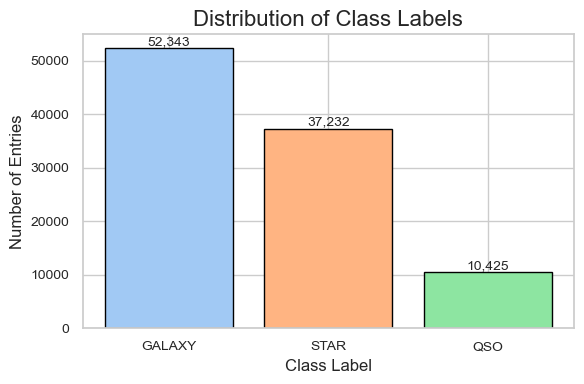

In [5]:
sns.set_theme(style="whitegrid")
class_counts = dataset['class'].value_counts()
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index, class_counts.values, color=sns.color_palette("pastel"), edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Class Labels", fontsize=16)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Entries", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
print('Galaxy:', round(dataset['class'].value_counts().iloc[0] / len(dataset) * 100, 2), '% of the dataset')
print('Star:', round(dataset['class'].value_counts().iloc[1] / len(dataset) * 100, 2), '% of the dataset')
print('Quasar:', round(dataset['class'].value_counts().iloc[2] / len(dataset) * 100, 2), '% of the dataset')

Galaxy: 52.34 % of the dataset
Star: 37.23 % of the dataset
Quasar: 10.42 % of the dataset


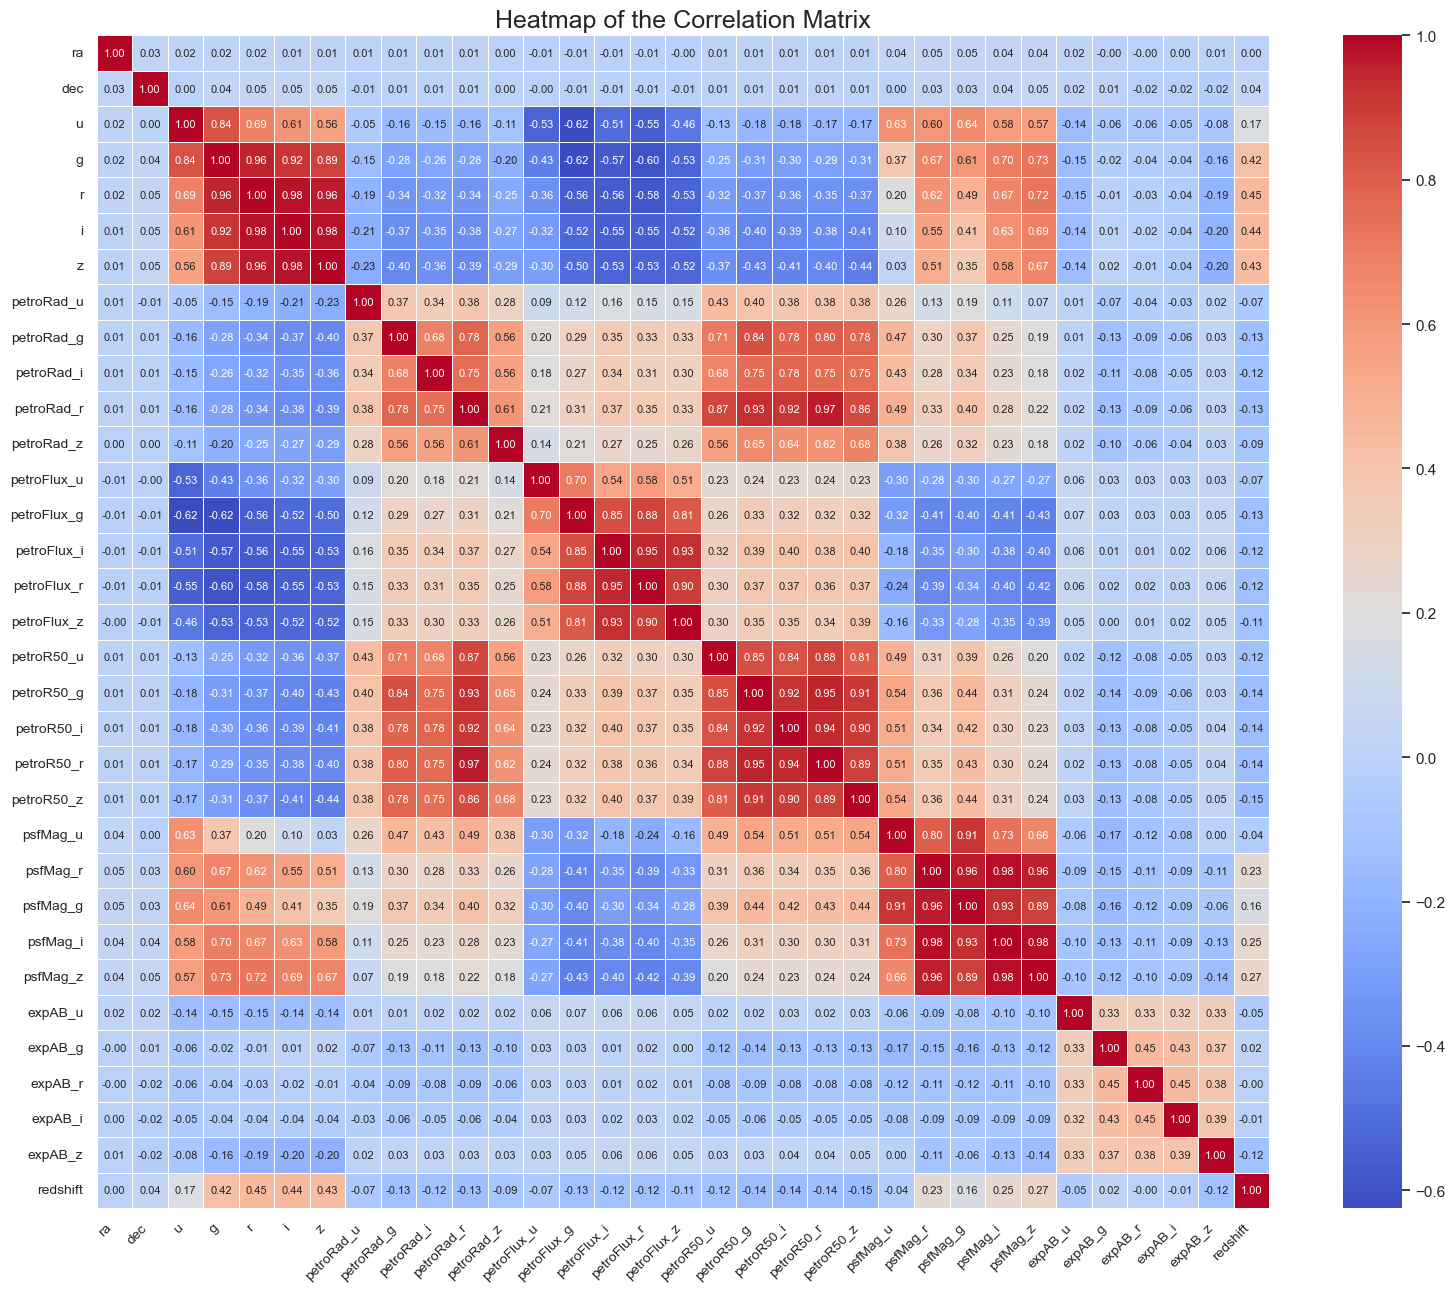

In [7]:
numeric_columns = dataset.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = dataset[numeric_columns].corr()
round(correlation_matrix, 2)
plt.figure(figsize=(16, 13))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 8},
    linewidths=0.5
)
plt.title("Heatmap of the Correlation Matrix", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

The dataset contains the 2D coordinates of each object on the celestial sphere (RA and DEC), which are like longitude and latitude for the sky. The redshift feature provides an important third dimension, which is distance.\
Due to the expansion of the universe, light from distant objects gets stretched to longer, redder wavelengths as it travels towards us. The amount of this "redshift" is directly related to the object's distance, a principle described by *Hubble's Law*.\
This analysis will use a simplified version of Hubble's Law to convert each object's redshift into an approximate distance in Megaparsecs (Mpc). By plotting the object's 2D positions along with the calculated distance, we can create a 3D map to visualize their spatial distribution.

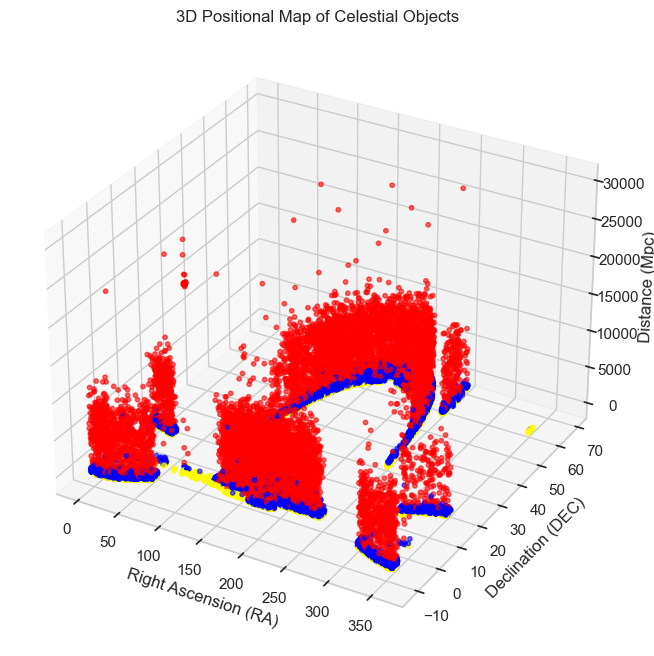

In [8]:
c = 3e5     # Speed of light
H0 = 70     # Hubble constant, rate of universe's expansion

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dataset['ra'],
    dataset['dec'],
    (c * dataset['redshift']) / H0,
    c=dataset['class'].map({'STAR': 'yellow', 'GALAXY': 'blue', 'QSO': 'red'}),
    alpha=0.6,
    s=10
)

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (DEC)')
ax.set_zlabel('Distance (Mpc)')
ax.set_title('3D Positional Map of Celestial Objects')
plt.show()

This 3D scatter plot confirms that the three classes of objects occupy distinct regions in space relative to us. The plot uses Right Ascension (RA) and Declination (DEC) for the 2D sky position, while redshift is used as an approximation for distance on the z-axis.\
Some of the key observations are:
- Stars (yellow) are all located in a very thin layer at the bottom of the plot, corresponding to a distance of almost zero. This is expected, as all the stars in this dataset are within our own galaxy and are close in a cosmo sense.
- Galaxies (blue) are distributed at low to moderate distances.
- Quasars (red) are scattered at the farthest distances on the plot. This confirms that quasars are the most distant objects in the dataset, which is why they have the highest redshift values.
- Survey Shape: The overall "striped" or "wedge" shape of the data points is a direct reflection of the way the Sloan Digital Sky Survey (SDSS) scans the sky. It doesn't observe the entire sky but focuses on specific regions, and this plot accurately shows those survey areas.

Redshift is a measure of how much light an object has been stretched to longer wavelengths. For distant objects outside our galaxy, this stretching is primarily caused by the expansion of the universe. According to Hubble's Law, a higher redshift corresponds to a greater distance. This makes redshift an important feature for distinguishing between different types of objects.

Visualizing the redshift distribution for each class will reveal three distinct patterns. Stars will have a redshift distribution peaked at zero. Galaxies will show a distribution at low to moderate positive redshifts. QSOs will have a much broader distribution that extends to significantly higher redshift values, confirming that redshift is a strong feature for classifying these objects

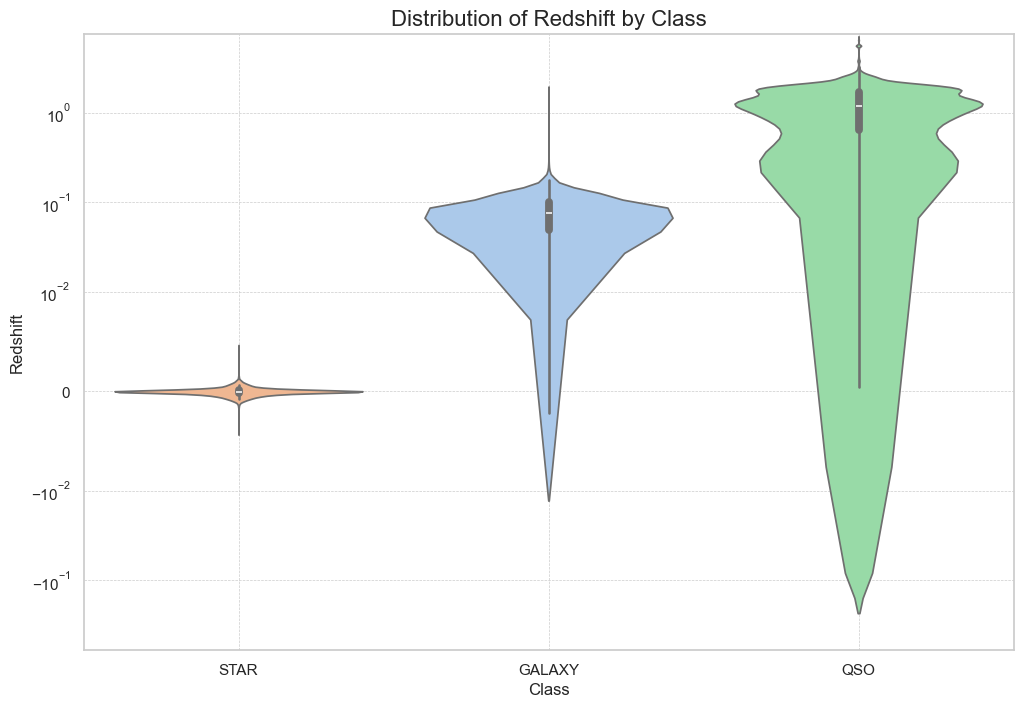

In [9]:
# Generate the violin plot.
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=dataset,
    x='class',
    y='redshift',
    hue='class',
    palette='pastel',
    order=['STAR', 'GALAXY', 'QSO'],
    legend=False
)
plt.yscale('symlog', linthresh=0.01)
plt.title("Distribution of Redshift by Class", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Redshift", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Now that we have a better generalization that redshift helps differentiating quasars from stars and galaxies, now we need to explore more and determine the differentiating factor between stars and galaxies, since galaxies consists of stars.\
\
Based on the description that [NASA](https://science.nasa.gov/ems/10_ultravioletwaves/) website provided about ultraviolet waves,\
"The difference in how the galaxies appear is due to which type of stars shine brightest in the optical and ultraviolet wavelengths. Ultraviolet images of galaxies show mainly clouds of gas containing newly formed stars that are many times more massive than the Sun and glow strongly in ultraviolet light. In contrast, visible light images of galaxies show mostly the yellow and red light of older stars. By comparing these types of data, astronomers can learn about the structure and evolution of galaxies."\
\
We use this information to determine *why* the different color filters are important for classification.

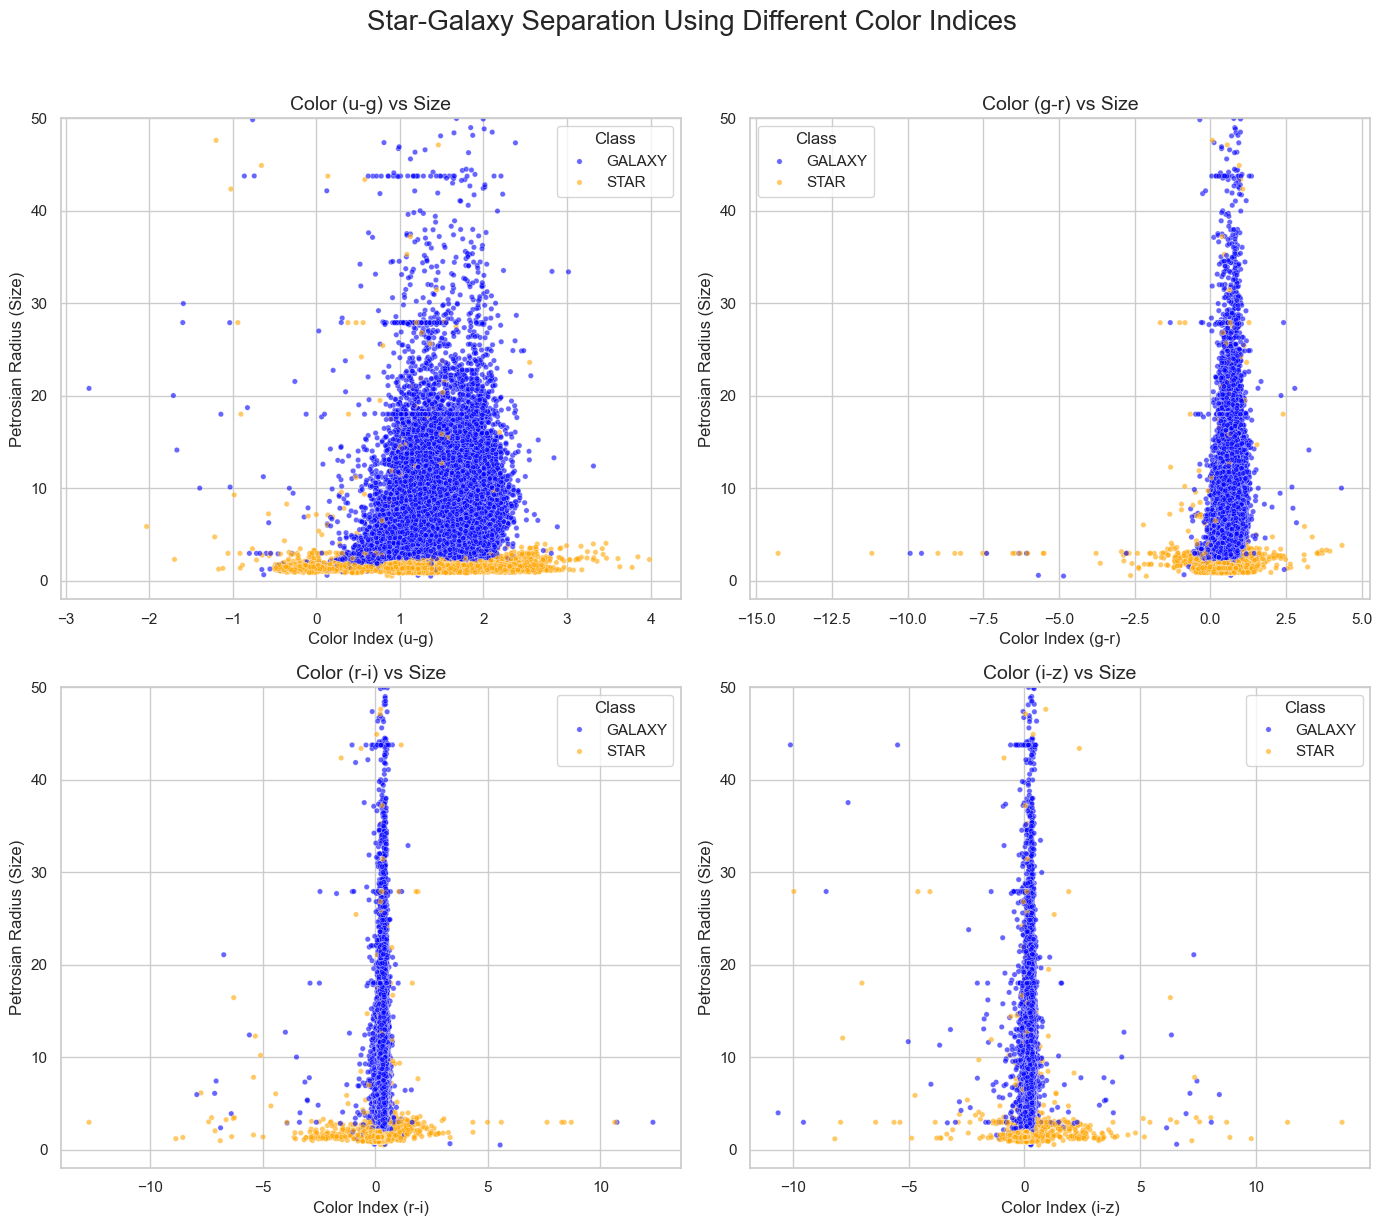

In [ ]:
# We will utilize different scatter plots that each shows the object's size (petroRad_r) on the y-axis
# and the different color index on the x-axis, in order to see the distinction between galaxies and stars.
df_cleaned = pd.read_csv("SDSS_DR18.csv")
df_cleaned.replace(-9999, np.nan, inplace=True)
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any() and pd.api.types.is_numeric_dtype(df_cleaned[col]):
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

# Full set of color index features.
df_cleaned['u-g'] = df_cleaned['u'] - df_cleaned['g']
df_cleaned['g-r'] = df_cleaned['g'] - df_cleaned['r']
df_cleaned['r-i'] = df_cleaned['r'] - df_cleaned['i']
df_cleaned['i-z'] = df_cleaned['i'] - df_cleaned['z']

# Filter the dataset include only Stars and Galaxies.
star_galaxy_data = df_cleaned[df_cleaned['class'].isin(['STAR', 'GALAXY'])]
color_indices = ['u-g', 'g-r', 'r-i', 'i-z']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Now we create a scatter plot.
for i, color_index in enumerate(color_indices):
    sns.scatterplot(
        data=star_galaxy_data,
        x=color_index,
        y='petroRad_r',
        hue='class',
        palette={'STAR': 'orange', 'GALAXY': 'blue'},
        alpha=0.6,
        s=15,
        ax=axes[i]
    )
    axes[i].set_title(f'Color ({color_index}) vs Size', fontsize=14)
    axes[i].set_xlabel(f'Color Index ({color_index})', fontsize=12)
    axes[i].set_ylabel(f'Petrosian Radius (Size)', fontsize=12)
    axes[i].legend(title='Class')
    axes[i].set_ylim(-2, 50)

plt.suptitle('Star-Galaxy Separation Using Different Color Indices', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

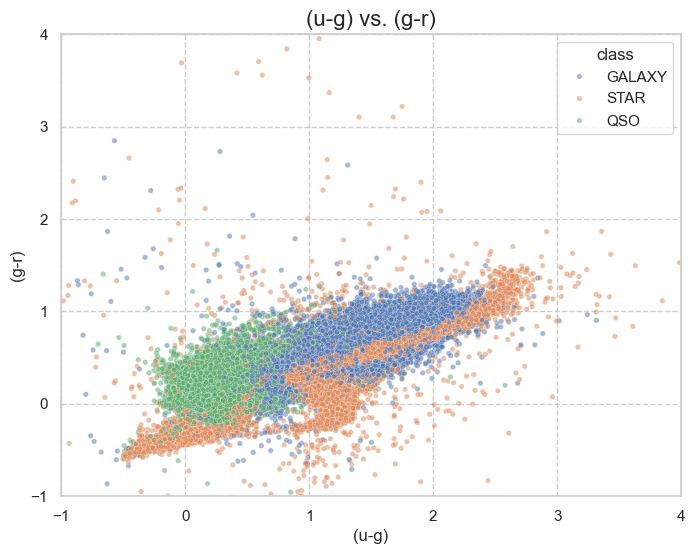

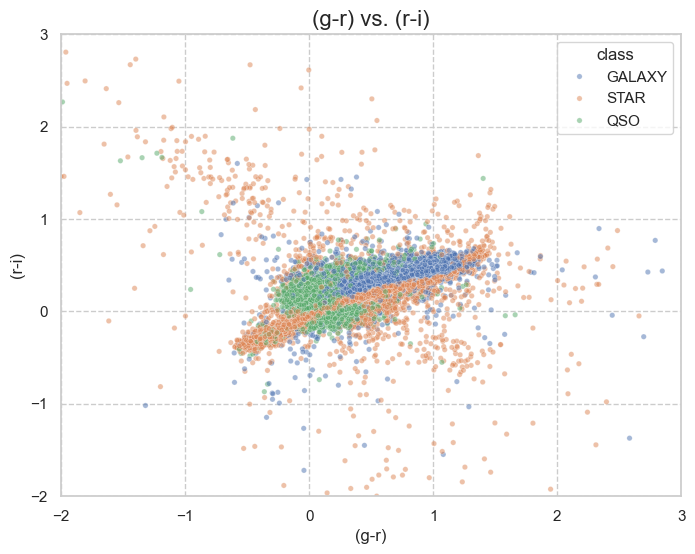

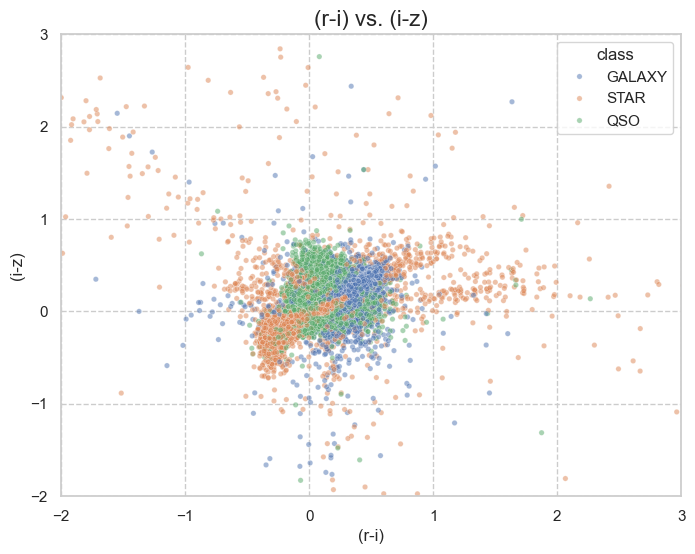

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_cleaned,
    x='u-g',
    y='g-r',
    hue='class',
    alpha=0.5,
    s=15
)

plt.title('(u-g) vs. (g-r)', fontsize=16)
plt.xlabel('(u-g)', fontsize=12)
plt.ylabel('(g-r)', fontsize=12)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.grid(True, which='both', linestyle='--')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_cleaned,
    x='g-r',
    y='r-i',
    hue='class',
    alpha=0.5,
    s=15
)

plt.title('(g-r) vs. (r-i)', fontsize=16)
plt.xlabel('(g-r)', fontsize=12)
plt.ylabel('(r-i)', fontsize=12)
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.grid(True, which='both', linestyle='--')
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_cleaned,
    x='r-i',
    y='i-z',
    hue='class',
    alpha=0.5,
    s=15
)

plt.title('(r-i) vs. (i-z)', fontsize=16)
plt.xlabel('(r-i)', fontsize=12)
plt.ylabel('(i-z)', fontsize=12)
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.grid(True, which='both', linestyle='--')
plt.show()

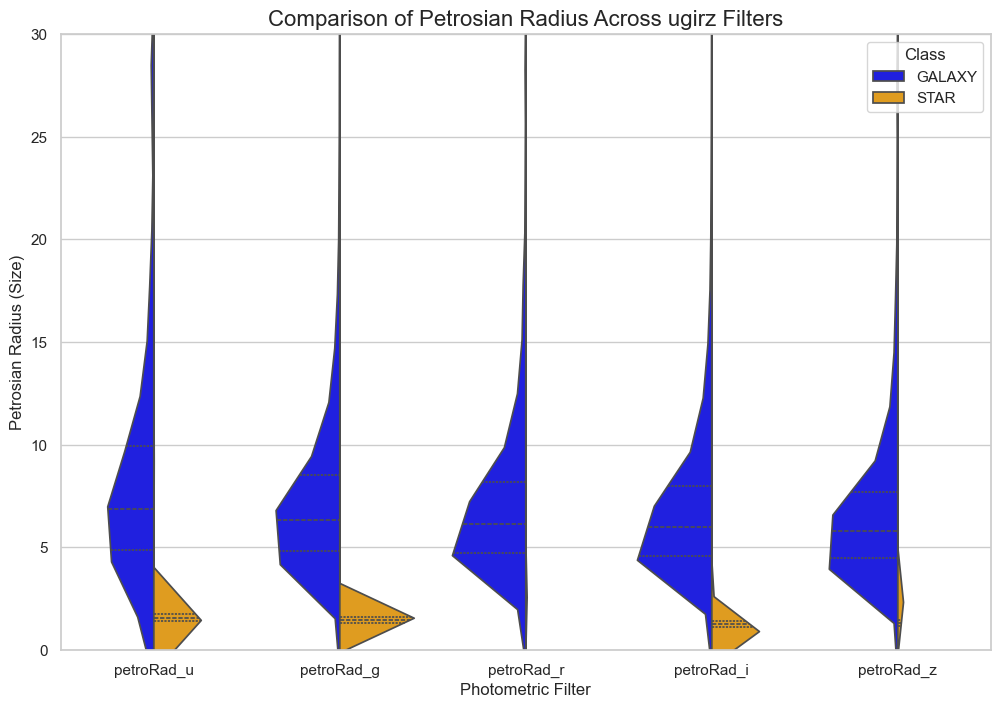

In [12]:
# Select the petroRad columns and 'class' for reshaping
petro_rad_cols = ['petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z']
data_to_melt = star_galaxy_data[petro_rad_cols + ['class']]

# Reshape the data from wide to long format
melted_data = data_to_melt.melt(
    id_vars='class',
    value_vars=petro_rad_cols,
    var_name='Filter',
    value_name='PetrosianRadius'
)

# Create the violin plots
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=melted_data,
    x='Filter',
    y='PetrosianRadius',
    hue='class',
    split=True,
    palette={'STAR': 'orange', 'GALAXY': 'blue'},
    inner='quartile'
)

plt.title('Comparison of Petrosian Radius Across ugirz Filters', fontsize=16)
plt.xlabel('Photometric Filter', fontsize=12)
plt.ylabel('Petrosian Radius (Size)', fontsize=12)
plt.ylim(0, 30)
plt.legend(title='Class')
plt.show()

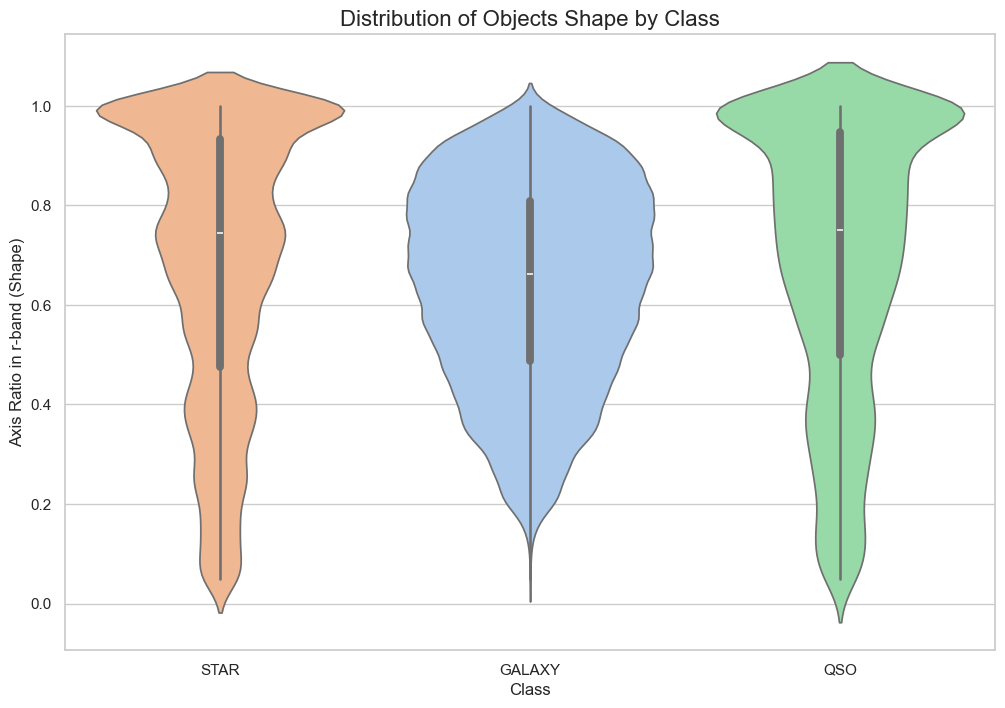

In [13]:
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=df_cleaned,
    x='class',
    y='expAB_r',
    hue='class',
    palette='pastel',
    order=['STAR', 'GALAXY', 'QSO']
)

plt.title("Distribution of Objects Shape by Class", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Axis Ratio in r-band (Shape)", fontsize=12)
plt.show()

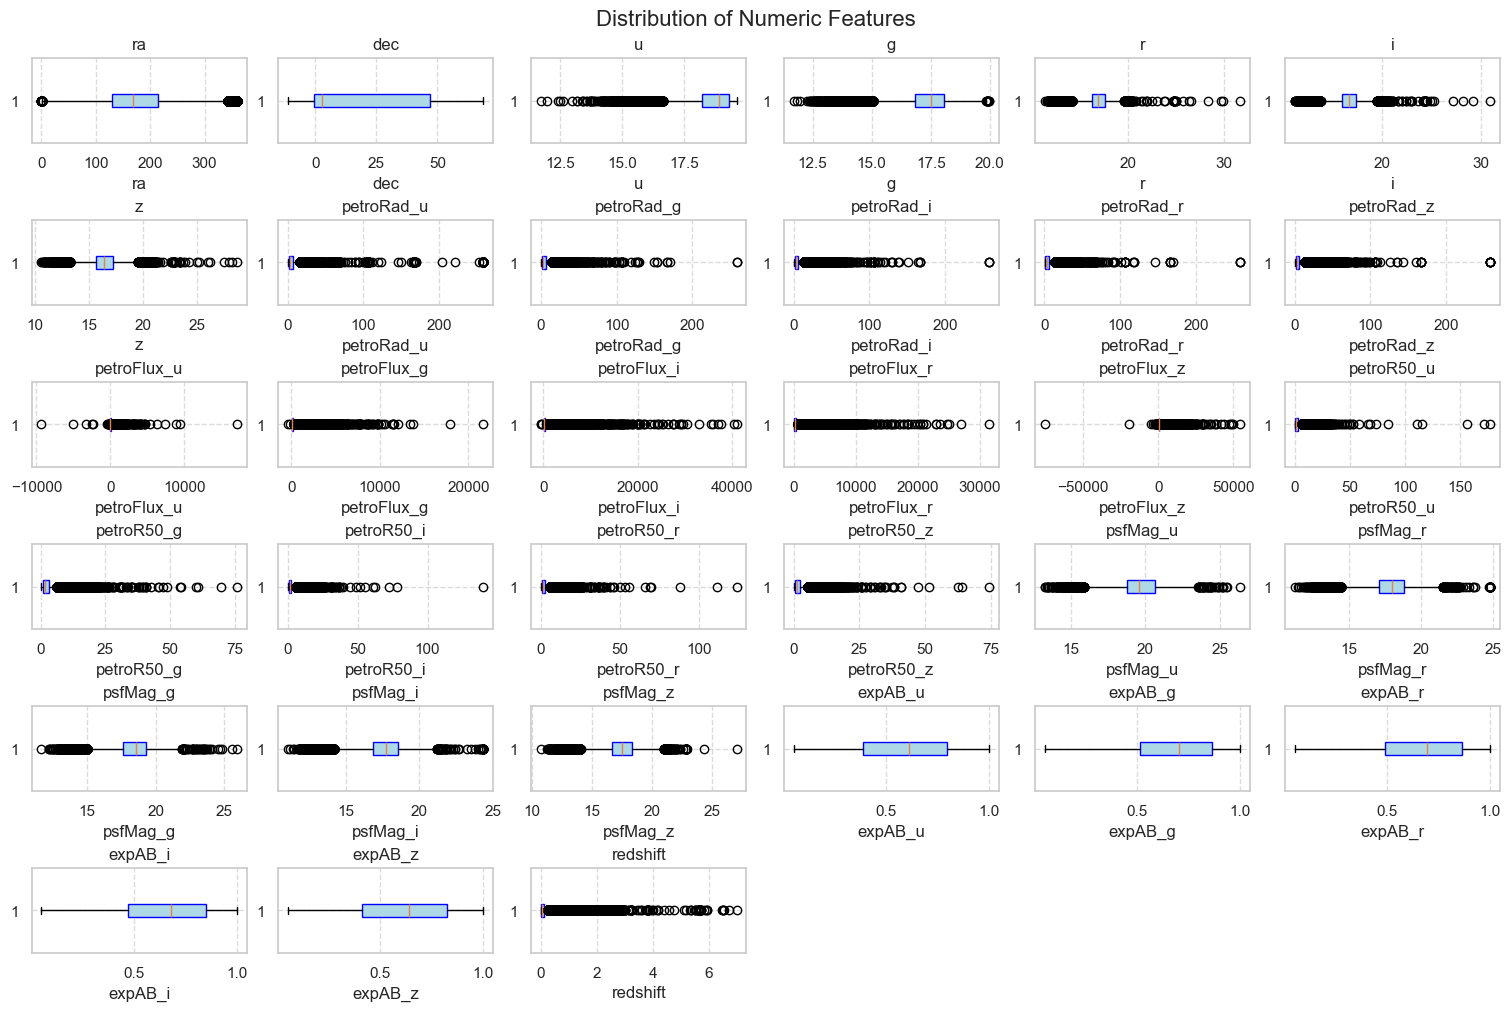

In [14]:
numeric_columns = dataset.select_dtypes(include=["float64"]).columns
grid_size = math.ceil(math.sqrt(len(numeric_columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numeric_columns):
    axes[idx].boxplot(dataset[col].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor="lightblue", color="blue"))
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis(('off'))

plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

### Model Training

In [15]:
features = dataset.drop(columns=['class'])
labels = dataset['class']

X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print("Original dataset proportions:\n", labels.value_counts(normalize=True))
print("\nTraining set proportions:\n", y_train.value_counts(normalize=True))

Original dataset proportions:
 class
GALAXY    0.52343
STAR      0.37232
QSO       0.10425
Name: proportion, dtype: float64

Training set proportions:
 class
GALAXY    0.523425
STAR      0.372325
QSO       0.104250
Name: proportion, dtype: float64


### Feature Scaling

In [16]:
scaler = RobustScaler()
train_features_scaled = scaler.fit_transform(X_train)
test_features_scaled = scaler.transform(X_test)

## Random Forest (Ensemble Classifier)

In [17]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=600,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=42)
rf_model = rf_clf.fit(train_features_scaled, y_train)
rf_preds = rf_clf.predict(test_features_scaled)

# Evaluation Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_preds)
rf_acc_score = accuracy_score(y_test, rf_preds)
rf_macro_f1 = f1_score(y_test, rf_preds, average="macro")
rf_class_report = classification_report(y_test, rf_preds)

print("Random Forest Confusion Matrix:\n", rf_conf_matrix)
print("Random Forest Accuracy:", rf_acc_score * 100,'\n')
print("Random Forest Macro-F1:", rf_macro_f1 * 100, '\n')
print("Random Forest Classification Report:\n", rf_class_report)

Random Forest Confusion Matrix:
 [[10404    29    36]
 [  115  1970     0]
 [    9     0  7437]]
Random Forest Accuracy: 99.055 

Random Forest Macro-F1: 98.42409588952485 

Random Forest Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     10469
         QSO       0.99      0.94      0.96      2085
        STAR       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.98     20000
weighted avg       0.99      0.99      0.99     20000



In [18]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, train_features_scaled, y_train, cv=kf, scoring='f1_weighted')

print("--- Baseline Model Performance ---")
print(f"Cross-validation F1 score: {scores}")
print(f"Average F1 score: {np.mean(scores):.4f}")
print(f"Standard deviation of F1 scores: {np.std(scores):.4f}")

--- Baseline Model Performance ---
Cross-validation F1 score: [0.99121259 0.99088302 0.99096    0.99053064 0.99070703]
Average F1 score: 0.9909
Standard deviation of F1 scores: 0.0002


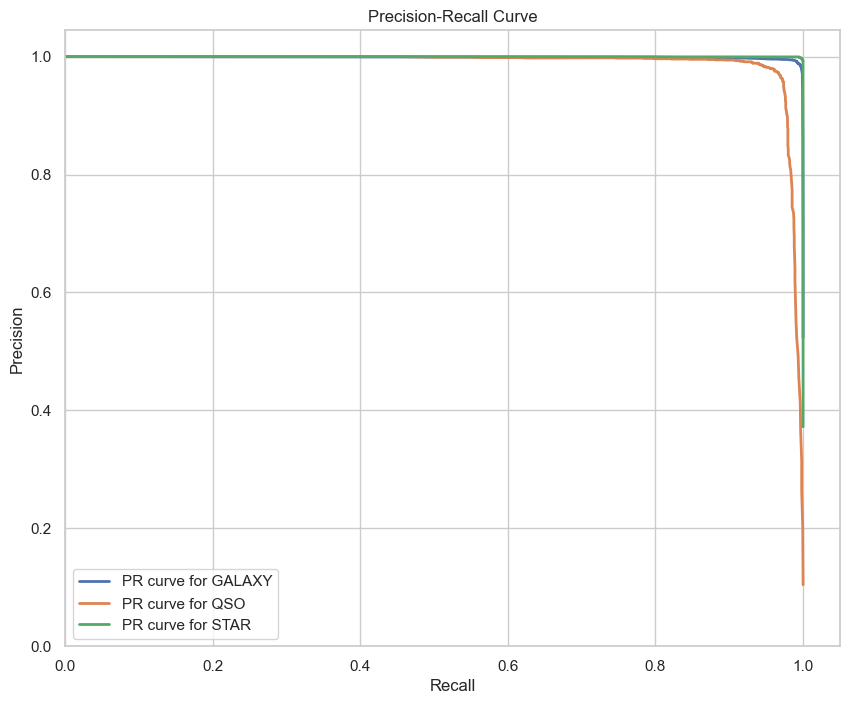

In [19]:
y_scores = rf_clf.predict_proba(test_features_scaled)

y_test_binarized = label_binarize(y_test, classes=rf_clf.classes_)
n_classes = len(rf_clf.classes_)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'PR curve for {rf_clf.classes_[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

In [20]:
smt = SMOTETomek(random_state=42)
train_features_smt, train_labels_smt = smt.fit_resample(
    train_features_scaled, y_train
)

rf_smt = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smt.fit(train_features_smt, train_labels_smt)
rf_preds_smt = rf_smt.predict(test_features_scaled)

print("--- MODEL PERFORMANCE (WITH SMOTETomek) ---")
print(classification_report(y_test, rf_preds_smt))

--- MODEL PERFORMANCE (WITH SMOTETomek) ---
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     10469
         QSO       0.97      0.96      0.97      2085
        STAR       0.99      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [21]:
# Evaluation Random Forest
rf_conf_smt = confusion_matrix(y_test, rf_preds_smt)
rf_acc_score_smt = accuracy_score(y_test, rf_preds_smt)
rf_macro_f1_smt = f1_score(y_test, rf_preds_smt, average="macro")

print("Random Forest Confusion Matrix:\n", rf_conf_smt)
print("Random Forest Accuracy:", rf_acc_score_smt * 100,'\n')
print("Random Forest Macro-F1:", rf_macro_f1_smt * 100, '\n')

Random Forest Confusion Matrix:
 [[10376    53    40]
 [   79  2006     0]
 [    8     0  7438]]
Random Forest Accuracy: 99.1 

Random Forest Macro-F1: 98.54437161361325 



In [ ]:
# Define features and labels for the baseline model
features_baseline = df_cleaned.drop(columns=['class'])
labels_baseline = df_cleaned['class']

# Split the data
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    features_baseline, labels_baseline, test_size=0.2, random_state=42, stratify=labels_baseline
)

# Train the baseline model
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train_base, y_train_base)
preds_baseline = rf_baseline.predict(X_test_base)

# Evaluate the baseline model
print("--- BASELINE MODEL PERFORMANCE (NO COLOR INDICES) ---")
print(classification_report(y_test_base, preds_baseline))

# Create a copy for feature engineering
df_engineered = df_cleaned.copy()

# Engineer the new color index features
df_engineered['u-g'] = df_engineered['u'] - df_engineered['g']
df_engineered['g-r'] = df_engineered['g'] - df_engineered['r']
df_engineered['r-i'] = df_engineered['r'] - df_engineered['i']
df_engineered['i-z'] = df_engineered['i'] - df_engineered['z']

# Drop the original, highly correlated magnitude columns
df_engineered = df_engineered.drop(columns=['u', 'g', 'r', 'i', 'z'])

# --- Repeat the training process with the new features ---

# Define features and labels for the engineered model
features_engineered = df_engineered.drop(columns=['class'])
labels_engineered = df_engineered['class']

# Split the data
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    features_engineered, labels_engineered, test_size=0.2, random_state=42, stratify=labels_engineered
)

# Train the engineered model
rf_engineered = RandomForestClassifier(n_estimators=100, random_state=42)
rf_engineered.fit(X_train_eng, y_train_eng)
preds_engineered = rf_engineered.predict(X_test_eng)

# Evaluate the engineered model
print("\\n--- IMPROVED MODEL PERFORMANCE (WITH COLOR INDICES) ---")
print(classification_report(y_test_eng, preds_engineered))


--- BASELINE MODEL PERFORMANCE (NO COLOR INDICES) ---
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     10469
         QSO       0.99      0.96      0.97      2085
        STAR       0.99      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000

\n--- IMPROVED MODEL PERFORMANCE (WITH COLOR INDICES) ---
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     10469
         QSO       0.99      0.96      0.97      2085
        STAR       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [23]:
rf_conf_smt = confusion_matrix(y_test, preds_engineered)
rf_acc_score_smt = accuracy_score(y_test, preds_engineered)
rf_macro_f1_smt = f1_score(y_test, preds_engineered, average="macro")

print("Random Forest Confusion Matrix:\n", rf_conf_smt)
print("Random Forest Accuracy:", rf_acc_score_smt * 100,'\n')
print("Random Forest Macro-F1:", rf_macro_f1_smt * 100, '\n')

Random Forest Confusion Matrix:
 [[10407    27    35]
 [   92  1993     0]
 [    4     0  7442]]
Random Forest Accuracy: 99.21 

Random Forest Macro-F1: 98.69545640149128 



In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

# 2. Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Apply SMOTE to the scaled training data to create the resampled sets
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Verification ---
print("Original training set shape:", X_train_scaled.shape)
print("Resampled training set shape:", X_train_resampled.shape)
print("\\nOriginal training set class distribution:\\n", y_train.value_counts())
print("\\nResampled training set class distribution:\\n", y_train_resampled.value_counts())

Original training set shape: (80000, 33)
Resampled training set shape: (125622, 33)
\nOriginal training set class distribution:\n class
GALAXY    41874
STAR      29786
QSO        8340
Name: count, dtype: int64
\nResampled training set class distribution:\n class
GALAXY    41874
STAR      41874
QSO       41874
Name: count, dtype: int64


# Optuna

In [28]:
# 1. Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'random_state': 42,
        'n_jobs': -1
    }

    # Create the Random Forest model with the suggested hyperparameters
    rf_clf = RandomForestClassifier(**params)

    # Evaluate the model using cross-validation
    # The goal is to maximize the F1-score, which balances precision and recall.
    score = cross_val_score(
        rf_clf, 
        X_train_resampled, 
        y_train_resampled, 
        cv=3, # Using 3 folds for a quicker run
        scoring='f1_weighted'
    )
    
    return np.mean(score)

# 2. Create a study object and run the optimization
# We set the direction to 'maximize' because a higher F1-score is better.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials to find the best parameters

# 3. Print the best results
print("\\nBest trial:")
trial = study.best_trial
print(f"  Value (F1-score): {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-13 19:48:07,580] A new study created in memory with name: no-name-1feb52bf-f0e5-405c-ae9d-9623f2b7ca76
[I 2025-09-13 19:48:50,858] Trial 0 finished with value: 0.9849006251280678 and parameters: {'n_estimators': 478, 'max_depth': 42, 'min_samples_split': 24, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.9849006251280678.
[I 2025-09-13 19:48:57,245] Trial 1 finished with value: 0.9840437840475138 and parameters: {'n_estimators': 57, 'max_depth': 32, 'min_samples_split': 14, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.9849006251280678.
[I 2025-09-13 19:49:22,649] Trial 2 finished with value: 0.985986437802624 and parameters: {'n_estimators': 256, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.985986437802624.
[I 2025-09-13 19:49:49,918] Trial 3 finished with value: 0.989451424060629 and parameters: {'n_estimators': 268, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with val

\nBest trial:
  Value (F1-score): 0.9908
  Best hyperparameters: 
    n_estimators: 317
    max_depth: 50
    min_samples_split: 2
    min_samples_leaf: 1


In [31]:
# 1. Create final model with the best hyperparameters from Optuna.
final_rf_model = RandomForestClassifier(
    n_estimators=317,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# 2. Train model on FULL resampled training data.
final_rf_model.fit(X_train_resampled, y_train_resampled)

# 3. Evaluate final model on test set.
final_preds = final_rf_model.predict(X_test_scaled)

final_con_matrix = confusion_matrix(y_test, final_preds)
final_acc_score = accuracy_score(y_test, final_preds)
final_macro_f1 = f1_score(y_test, final_preds, average="macro")
final_class_report = classification_report(y_test, final_preds)

print("--- Final Tuned Model Performace ---")
print("Random Forest Confusion Matrix:\n", final_con_matrix)
print("Random Forest Accuracy:", final_acc_score * 100,'\n')
print("Random Forest Macro-F1:", final_macro_f1 * 100, '\n')
print("Random Forest Classification Report:\n", final_class_report)

--- Final Tuned Model Performace ---
Random Forest Confusion Matrix:
 [[10383    50    36]
 [   77  2008     0]
 [    7     0  7439]]
Random Forest Accuracy: 99.15 

Random Forest Macro-F1: 98.6114685176314 

Random Forest Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     10469
         QSO       0.98      0.96      0.97      2085
        STAR       1.00      1.00      1.00      7446

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000

